# Machine Learning project
By Mattia Barbiere

In [335]:
import sys
import sklearn
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

## The Data

Before we try to fit the models we should first see what kind of data we are dealing with. This helps us to get a feel for the data so we can already start understanding where our models are a good choice or not.

In [336]:
df = pd.read_csv("mldata_0003151393.csv", index_col=0)
X = df[df.columns[1:]]
y = df['label']

In [337]:
df.head(10)

,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,1,-2.887351,2.368955,-0.625925,-3.978334,-0.326955,4.055608,-0.235264,0.273827,-0.517484,...,1.510891,-0.111374,0.940897,-3.955810,-0.363500,0.199346,0.461904,-0.126972,1.626261,-0.182263
1,3,1.334865,-1.751757,-0.578244,-2.852914,-0.046243,-0.404612,4.838986,2.054794,0.641435,...,-1.172510,-0.015095,0.175453,-2.446950,-0.718050,0.596897,0.170454,-1.004904,2.982466,-3.522866
2,0,-1.073810,3.398483,-1.099216,1.529714,1.319205,4.183233,-4.627822,0.452511,3.557216,...,0.821012,6.678114,-0.540001,1.582700,0.466075,-2.284209,0.133034,0.216640,2.448328,2.277177
3,3,-1.459105,0.604342,-0.052011,0.196076,2.174851,-0.732217,-1.997095,2.443736,3.655130,...,0.491459,-0.112123,1.388338,-2.690753,0.997441,-0.957406,-1.423567,-0.276991,0.858894,-0.212745
4,2,0.508266,3.532480,-0.196915,-3.370030,0.177465,0.025390,2.840482,1.251280,-3.536680,...,0.758948,-5.192279,-0.341884,-2.078780,1.978526,1.532484,2.001019,-1.013421,-1.295467,-1.002012
5,4,-0.316656,-0.922855,1.447635,1.699483,0.022101,0.473463,-0.126300,0.966990,1.545700,...,-0.574484,2.309736,-1.206329,0.574633,-0.158552,-1.874306,0.576478,-0.918869,-0.961063,0.828915
6,3,-0.350357,-0.280938,1.572685,0.922978,2.159589,-1.828143,1.953110,1.780278,0.755949,...,-0.297084,1.999719,1.578167,-0.109991,0.199291,-2.984111,0.158336,-1.480244,-0.604203,-1.328385
7,2,1.512664,2.661731,-1.997446,-0.114986,-0.558272,-0.272194,2.245315,2.066404,1.031266,...,-1.191092,-4.413065,1.049424,-2.668520,-0.566365,0.140097,1.048035,-0.162599,-2.040033,-0.893740
8,2,-1.331660,0.894030,0.167612,-2.500779,2.216463,5.035682,-5.196242,0.905760,2.859414,...,-0.008510,4.528739,0.215946,0.495931,-1.454981,0.590947,-0.027441,0.839361,2.616551,3.506210
9,3,0.437816,-0.601652,-0.031859,-1.010379,-1.492245,1.222452,3.299241,0.504061,-0.439967,...,-0.762156,-3.027410,-1.525858,-2.826487,1.820201,1.583277,-0.455038,-1.004994,-0.963731,-2.737519


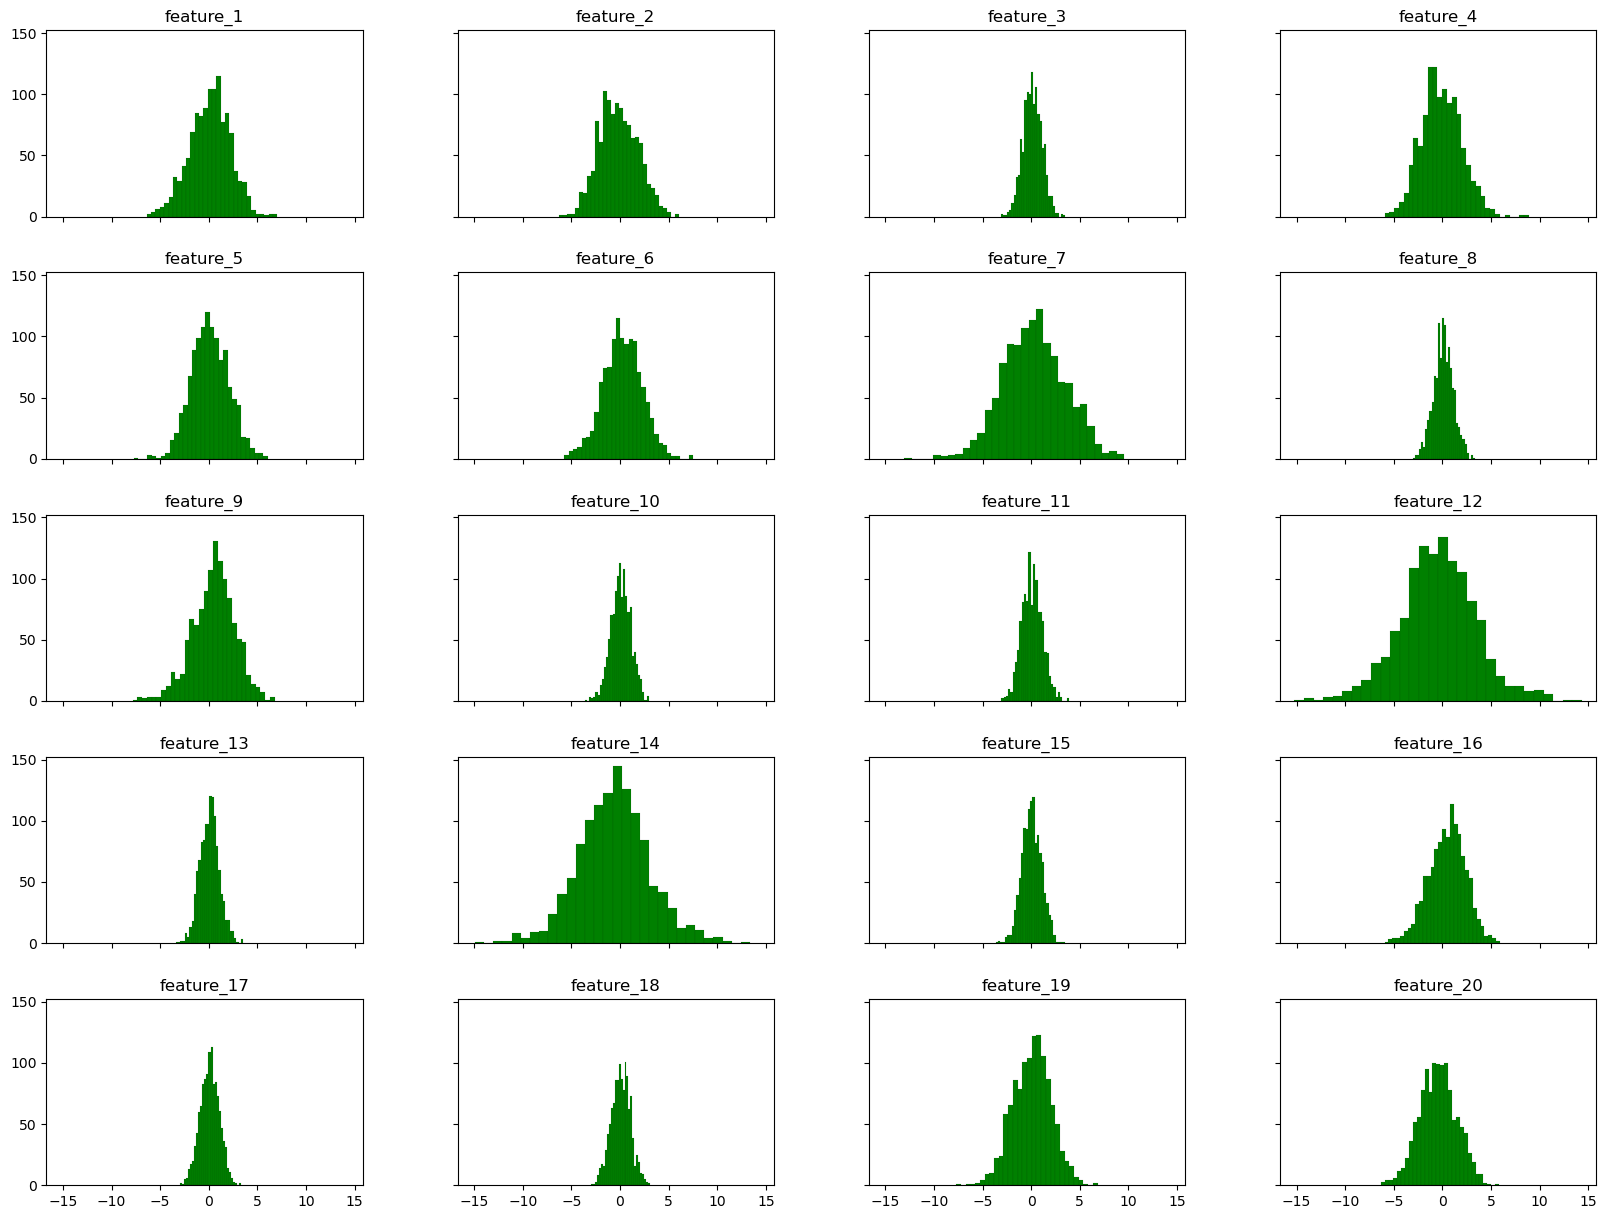

In [338]:
X.hist(bins=30, figsize=(20,15), 
                        color="green",
                        ec="black", 
                        lw=0.05, 
                        grid=False, 
                        sharex='col', 
                        sharey='row')
plt.show()


From the graphs above we see that the features were generated probably by a normal distribiution with mean 0. The variance amoung the features however is different. We see that `feature_17` has a much smaller variance compared to `feature_1`. This is exactly what we see when we caluculate the means and standerd deviations of all the features. 

In [339]:
print("Number of missing values: ", df.isna().sum().sum())
X.describe().T

Number of missing values:  0


,count,mean,std,min,25%,50%,75%,max
feature_1,1200.0,0.101575,2.078299,-6.378028,-1.287177,0.221206,1.564032,7.044498
feature_2,1200.0,-0.166710,1.981571,-6.266420,-1.594085,-0.263605,1.224438,6.042347
feature_3,1200.0,0.132981,0.967590,-3.145218,-0.512257,0.125932,0.793849,3.520966
feature_4,1200.0,-0.087112,2.053683,-5.960159,-1.482476,-0.149005,1.324697,8.877270
feature_5,1200.0,0.125522,1.938720,-7.697257,-1.158171,0.069604,1.465483,6.083652
feature_6,1200.0,0.253446,2.006632,-5.721129,-1.060267,0.230359,1.581070,7.492904
feature_7,1200.0,0.313112,3.200007,-13.068389,-1.906664,0.277519,2.503021,9.531424
feature_8,1200.0,0.107007,1.010086,-3.038071,-0.543744,0.112021,0.779632,3.329917
feature_9,1200.0,0.488320,2.187284,-7.828465,-0.844002,0.640040,1.920727,6.772510
feature_10,1200.0,0.093529,1.012772,-3.620827,-0.581886,0.086866,0.794594,2.951366


Total average correlation:  0.05599543199968648
Average correlation for each feature: 
 feature_1     0.098121
feature_2    -0.004305
feature_3     0.041617
feature_4     0.035590
feature_5     0.072204
feature_6     0.111855
feature_7    -0.063248
feature_8     0.046115
feature_9     0.012310
feature_10    0.051752
feature_11    0.045150
feature_12    0.135671
feature_13    0.059532
feature_14    0.138615
feature_15    0.058017
feature_16    0.025011
feature_17    0.043796
feature_18    0.050822
feature_19    0.075835
feature_20    0.085448
dtype: float64


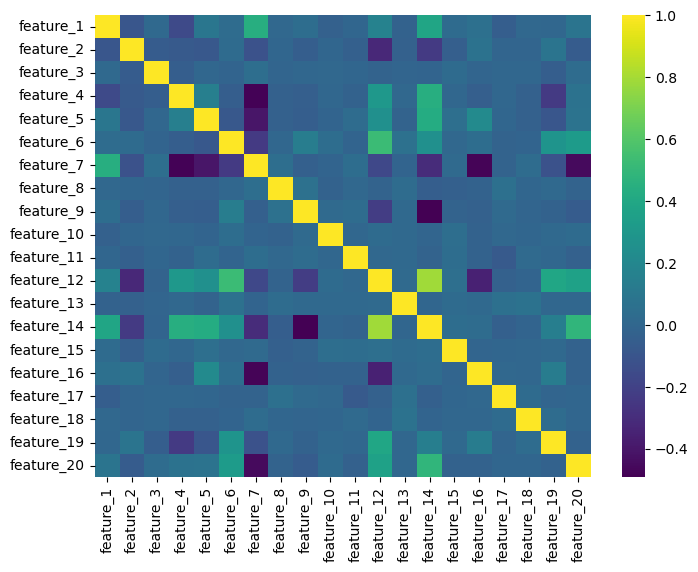

In [340]:
#Correlation amoung features
plt.figure(figsize=(8,6))
sns.heatmap(X.corr(), cmap='viridis')
print("Total average correlation: ", X.corr().stack().mean())
print("Average correlation for each feature: \n", X.corr().mean())

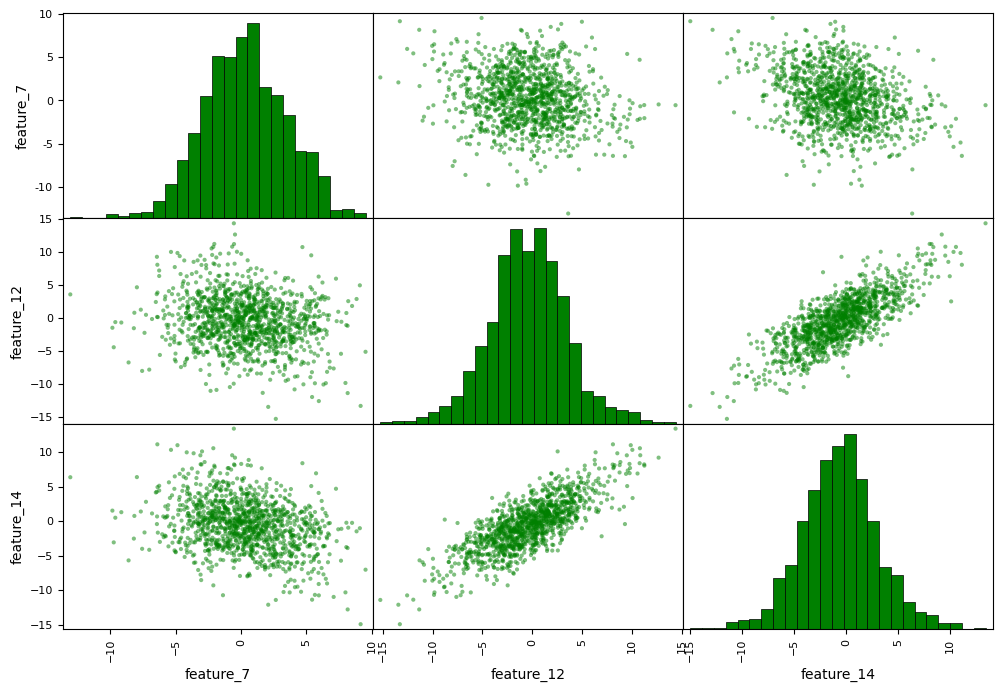

In [341]:
from pandas.plotting import scatter_matrix
feats = ["feature_7", "feature_12", "feature_14"]
scatter_matrix(df[feats], figsize=(12, 8), c="green", 
               hist_kwds={'bins': 25, 'color':"green", 'ec': 'black', 'lw': 0.5})
plt.show()


## Defining and training the models

We can now start working with the models. We have 5 different kinds of labels in our dataset. Our objective is to fit logistic regression and K nearest neighbor so that we can test their performance and see which one is the best model. Before training we should check is that we have sufficient examples for each label.

In [342]:
# Percentage of examples for each label
round((y.value_counts().sort_index()/df.shape[0]) * 100, 2)

0    20.33
1    18.58
2    20.50
3    20.50
4    20.08
Name: label, dtype: float64

Overall the examples for each label are very balanced. This a a good sign as we have sufficent examples to train our classifiers. This also removes a layer of complexity in our models.

The next step are the actual models. As always we start of splitting the data into train and test sets in order to test the models on new data later on.

In [343]:
from sklearn.model_selection import train_test_split

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

To define the models we start of with a pipeline. This is a very simple pipeline as there is no imputing or transformation to do with the data. Notice that we add `('scaler', None)` to the pipeline. As we show in the histograms above our data already has a gaussian distribiution with mean close to 0 and standard deviation between 1 and 3. For this reason there might be no reason to scale the data, however we add `('scaler', None)` as a placeholder as we will run Grid Search to see where accuracy improves or not by applying the scaler. Unsurprisingly it doesn't.

In [344]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Making the one pipeline for each model
#-------K Nearest Neighbor-------
pipe_knn = Pipeline([
        ('scaler', None),
        ('KNN_model', KNeighborsClassifier())
    ])

#-------Logistic Regression-------
pipe_logi = Pipeline([
        ('scaler', None),
        ('logi_model', LogisticRegression(random_state=0))
    ])

#Fitting
pipe_logi.fit(X_train,y_train)
pipe_knn.fit(X_train,y_train)

print(pipe_logi, pipe_knn)

Pipeline(steps=[('scaler', None),
                ('logi_model', LogisticRegression(random_state=0))]) Pipeline(steps=[('scaler', None), ('KNN_model', KNeighborsClassifier())])


## Performance Measures

The main objective of this project was comparing K Nearest Neighbor to Logistic Regression. In order to do so we need to evaluate the performance of the two models in such a way we can compare the outcomes.
As performance measures I chose:
* item `pipeline.score(X_test, y_test)`: This simply evaluates the model with the test data and comparing it to the true labels to get a score of the model
* item `cross_val_score().mean()`: This will give us a score while eliminating any bias we have in our train-test split. We then take the mean over all the k folds
* item `Confusion Matrix`: With the confusion matrix will be able to understand where are models are misclassifying the labels

In [357]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

kfold = KFold(shuffle=True, n_splits=10)
#A function which returns all the permormance measures we want
def permormance(pipeline: sklearn.pipeline.Pipeline, title: str, when: str):
      """
      Given as input a pipeline (with a model) and a title it returns some performance measures of that pipeline
      """
      if when == "before":
            print("Performance Measures before Grid Search:")
      elif when == "after":
            print("Performance Measures after Grid Search:")

      print(" " + title + " score: ", f"{round(pipeline.score(X_test, y_test) * 100,2)}%")
      print(" " + title + " mean CV score: ", 
            f"{round(cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy').mean() * 100,2)}%")
      print(" " + title + " Confusion matrix: \n", confusion_matrix(pipeline.predict(X), y), "\n")

#Performance measures before Grid Search
#-------K Nearest Neighbor-------
permormance(pipe_knn, "K Nearest Neighbor", "before")

#-------Logistic Regression-------
permormance(pipe_logi, "Logistic Regression", "before")

Performance Measures before Grid Search:
 K Nearest Neighbor score:  72.92%
 K Nearest Neighbor mean CV score:  71.67%
 K Nearest Neighbor Confusion matrix: 
 [[224   3   3   2   3]
 [  4 207   1   3   2]
 [  3   3 233   0   1]
 [  8   2   4 238   2]
 [  5   8   5   3 233]] 

Performance Measures before Grid Search:
 Logistic Regression score:  46.67%
 Logistic Regression mean CV score:  47.08%
 Logistic Regression Confusion matrix: 
 [[104  60  24  27  27]
 [ 14  36  12  15   8]
 [ 43  44 151  11  33]
 [ 51  50  17 147  22]
 [ 32  33  42  46 151]] 



In [351]:
from sklearn.model_selection import GridSearchCV

#Grid search for K Nearest Neighbors
g_param_knn = {'scaler': [StandardScaler(), MinMaxScaler(), None],
                'KNN_model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                'KNN_model__leaf_size': [10, 20, 30, 40, 50],
                'KNN_model__p': [0, 1, 2],
                'KNN_model__weights': ['uniform', 'distance']}
g_knn = GridSearchCV(pipe_knn, g_param_knn, cv=kfold, scoring='accuracy', n_jobs=-1)
g_knn.fit(X, y)

#Results of Grid Search
print("Best score from Grid Search for KNN: ", f"{round(g_knn.best_score_ * 100, 2)}%")
print("Best parameters given by Grid Search for KNN: ")
g_knn.best_params_


#  'KNN_model': KNeighborsClassifier(),
#  'KNN_model__algorithm': 'auto',
#  'KNN_model__leaf_size': 30,
#  'KNN_model__metric': 'minkowski',
#  'KNN_model__metric_params': None,
#  'KNN_model__n_jobs': None,
#  'KNN_model__n_neighbors': 5,
#  'KNN_model__p': 2,
#  'KNN_model__weights': 'uniform'}


Best score from Grid Search for KNN:  70.58%
Best parameters given by Grid Search for KNN: 


{'KNN_model__algorithm': 'auto',
 'KNN_model__leaf_size': 10,
 'KNN_model__p': 2,
 'KNN_model__weights': 'distance',
 'scaler': None}

In [347]:
pipe_knn.set_params(**g_knn.best_params_)
pipe_knn.fit(X_train,y_train)

permormance(pipe_knn, "K Nearest Neighbor", "after")


K Nearest Neighbor score before Grid Search:  72.92%
K Nearest Neighbor mean CV score before Grid Search:  71.33%
K Nearest Neighbor Confusion matrix: 
 [[224   3   3   2   3]
 [  4 207   1   3   2]
 [  3   3 233   0   1]
 [  8   2   4 238   2]
 [  5   8   5   3 233]] 



In [348]:
#Grid search for Logistic Regression
g_param_logi = {'scaler': [StandardScaler(), MinMaxScaler(), None],
                'logi_model__penalty' : ['l1', 'l2', 'elasticnet', None],
                'logi_model__C' : np.logspace(-5, 5, 10),
                'logi_model__multi_class': ['multinomial', 'ovr'],
                'logi_model__l1_ratio': [0.25, 0.5, 0.75],
               }
g_logi = GridSearchCV(pipe_logi, g_param_logi, cv=kfold, scoring='accuracy', n_jobs=-1)
g_logi.fit(X, y)

#Results of Grid Search
print("Best score from Grid Search: ", f"{round(g_logi.best_score_ * 100, 2)}%")
g_logi.best_params_


Best score from Grid Search:  0.4783333333333334


{'logi_model__C': 0.021544346900318846,
 'logi_model__l1_ratio': 0.25,
 'logi_model__multi_class': 'multinomial',
 'logi_model__penalty': 'l2',
 'scaler': None}

In [352]:
pipe_logi.set_params(**g_logi.best_params_)
pipe_logi.fit(X_train,y_train)
permormance(pipe_logi, "Logistic Regression", "after")


TypeError: permormance() takes 2 positional arguments but 3 were given

## Conclusion

The best model in our case is KNN

In [350]:
g_knn.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', None),
  ('KNN_model', KNeighborsClassifier(leaf_size=10, weights='distance'))],
 'verbose': False,
 'scaler': None,
 'KNN_model': KNeighborsClassifier(leaf_size=10, weights='distance'),
 'KNN_model__algorithm': 'auto',
 'KNN_model__leaf_size': 10,
 'KNN_model__metric': 'minkowski',
 'KNN_model__metric_params': None,
 'KNN_model__n_jobs': None,
 'KNN_model__n_neighbors': 5,
 'KNN_model__p': 2,
 'KNN_model__weights': 'distance'}